# NHL Fantasy, pelaajien pisteiden ennakointi

Olen useiden vuosien ajan pelannut NHL Fantasy peliä ystävieni kanssa. https://hockey.fantasysports.yahoo.com/ En avaa pelin sääntöjä tai muita yksityiskohtia tarkemmin, sillä ne eivät ole relevantteja. Lyhyesti kyseisessä pelissä, kisataan toisia pelaajia eli usein ystäviä vastaan ja pyritään kasaamaan paras mahdollinen joukkue. Pelaaja, joka onnistuu kasaamaan parhaan joukkueen ja kerämään eniten pisteitä voittaa pelin. Jokainen osallistuja valitsee vuorotellen itselleen pelaajan ja näistä pelaajista muodostuu jokaisen joukkue. Useampi osallistuja ei voi valita samaa pelaajaa. Jokaisen pelaajan tulee valita itselleen 19 kenttäpelaajaa ja 2 maalivahtia, tässä projektissa en ole ottanut maalivahteja mukaan, sillä heidän datansa on hyvin erilaista kuin kenttäpelaajien.

Pelaajien dataa on haettu projektissa kahdesta erillisesta paikasta. https://www.rotowire.com/hockey/stats.php josta jokaisen kauden tiedot saa kätevästi csv tiedostoksi. Datalähde sisältää lähes kaikki yleisimmät tiedot joita pelaajista kerätään. Toinen datalähde on hyvin paljon laajempi ja se kerää osittain samoja tietoja, mutta hyvin paljon enemmän. https://moneypuck.com/data.htm myös tämä data on csv muodossa. Datat löytyvät omista kansioistaan, NHLplayerStats sisältää https://www.rotowire.com/hockey/stats.php sivulta saadun datan ja NHLSkaterStats https://moneypuck.com/data.htm sivun datan. Datassa on käytetty vuosien 2017-2023 dataa.

In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Luodaan dataframe, jossa on esitetty jokainen tutkittava tieto, sen lyhenne, paljonko pelissä siitä saa pisteitä ja sen laajempi selitys

In [22]:
stat_info_category = {
    "Name": ["Goal", "Assists", "Plus/Minus(+/-)", "Penalty Minutes", "Powerplay Points", "Shorthanded Points",
             "Game-Winning Goals", "Shot on Goal", "Faceoffs Won", "Faceoffs Lost", "Hits", "Blocks"],
    "Abbreviation": ["G", "A", "+/-", "PIM", "PPP", "SHP", "GWG", "SOG", "FW", "FL", "H", "BL"],
    "Points": [6, 4, 2, -1, 1, 3, 4, 0.5, 0.3, -0.3, 1, 1],
    "Explanation": [
        "Goals scored by the player.",
        "Primary and secondary assists; passes leading directly or indirectly to a goal by a teammate.",
        "The difference in goals scored by the player's team and goals scored against while the player is on the ice.",
        "Time spent in the penalty box for infractions.",
        "Points earned by the player while their team is on a powerplay.",
        "Points earned by the player while their team is shorthanded.",
        "Goals scored by the player that lead to their team winning the game.",
        "Shots taken by the player that are aimed at the opposing team's net.",
        "Number of faceoffs won by the player.",
        "Number of faceoffs lost by the player.",
        "Physical contact made by the player against opponents.",
        "Times the player blocks the opposing team's shot attempts."
    ]
}

player_stat_info_category_df = pd.DataFrame(stat_info_category)
player_stat_info_category_df

,Name,Abbreviation,Points,Explanation
0,Goal,G,6.0,Goals scored by the player.
1,Assists,A,4.0,Primary and secondary assists; passes leading ...
2,Plus/Minus(+/-),+/-,2.0,The difference in goals scored by the player's...
3,Penalty Minutes,PIM,-1.0,Time spent in the penalty box for infractions.
4,Powerplay Points,PPP,1.0,Points earned by the player while their team i...
5,Shorthanded Points,SHP,3.0,Points earned by the player while their team i...
6,Game-Winning Goals,GWG,4.0,Goals scored by the player that lead to their ...
7,Shot on Goal,SOG,0.5,Shots taken by the player that are aimed at th...
8,Faceoffs Won,FW,0.3,Number of faceoffs won by the player.
9,Faceoffs Lost,FL,-0.3,Number of faceoffs lost by the player.


In [23]:
# Haetaan tiedot csv tiedostoista
# Polku kansioon, jossa pelaajien tiedot ovat
directoryPlayerStats = 'NHLplayerStats/'

# Luodaan tyhjä lista, johon tallennetaan tiedot
df_PlayerStats_list = []

# Käy läpi jokainen CSV-tiedosto
for filename in os.listdir(directoryPlayerStats):
    if filename.endswith(".csv"):
        # CSV tiedostojen lukeminen df ja varmistetään että ensimmäinen rivi on otsikko rivi
        df_Player = pd.read_csv(os.path.join(directoryPlayerStats, filename), header=1)

        # Sarakkeiden nimien muuttaminen
        df_Player.rename(columns={"G.1": "G(PP)", "A.1": "A(PP)", "G.2": "G(SH)", "A.2": "A(SH)"}, inplace=True)
        
        # Tiedoston nimestä otetaan vuosi jolta data on
        year = filename.split('-')[-1].split('.')[0]
        
        # Lisätään season saraka jota ei ole, ja asetetaan arvoksi tiedoston nimestä otettu vuosi
        df_Player['season'] = year

        df_PlayerStats_list.append(df_Player)

# Dataframejen yhdistäminen
combined_player_stats_df = pd.concat(df_PlayerStats_list, ignore_index=True)

# Laitetaan sarakkeet selkeämpään järjestykseen
combined_player_stats_df = combined_player_stats_df[['Player Name', 'Team', 'season', 'Pos',  'Games',   'G', 'A', 'Pts', '+/-', 'PIM', 'SOG', 'GWG', 'G(PP)', 'A(PP)', 'G(SH)', 'A(SH)', 'Hits' , 'BS']]
combined_player_stats_df

,Player Name,Team,season,Pos,Games,G,A,Pts,+/-,PIM,SOG,GWG,G(PP),A(PP),G(SH),A(SH),Hits,BS
0,Alex Ovechkin,WAS,2017,LW,82,49,38,87,3,32,355,7,17,14,0,0,139,21
1,Patrik Laine,CLS,2017,RW,82,44,26,70,8,24,241,8,20,11,0,0,74,43
2,William Karlsson,VGK,2017,C,82,43,35,78,49,12,184,6,8,8,4,1,48,45
3,Evgeni Malkin,PIT,2017,C,78,42,56,98,16,87,239,7,14,24,0,0,48,32
4,Eric Staal,FA,2017,C,82,42,34,76,8,42,241,4,11,6,2,1,42,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6466,Cameron Butler,CLS,2023,RW,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6467,Vincent Iorio,WAS,2023,D,6,0,0,0,1,0,6,0,0,0,0,0,3,3
6468,Ryan Winterton,SEA,2023,C,9,0,0,0,-1,0,10,0,0,0,0,0,10,4
6469,Ethan Del Mastro,CHI,2023,D,2,0,0,0,0,0,0,0,0,0,0,0,2,0


In [24]:
# Tehdään vastaava myös laajemmalle datalle joka on toisessa kansiossa

data_directory = "NHLSkaterStats/"

dataframes = []

for filename in os.listdir(data_directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(data_directory, filename))
        dataframes.append(df)

yhdistetty_df = pd.concat(dataframes, ignore_index=True)

# Valitaan datasta vain ne kohdat joissa situation = all
suodatettu_df = yhdistetty_df[yhdistetty_df["situation"] == "all"]

# Datasta valitaan vain tietyt osiot eli kausi, nimi, joukkue, aloitusvoitot ja tappiot
valitut_sarakkeet = ["season", "name", "team", "faceoffsWon", "faceoffsLost"]
suodatettu_df = suodatettu_df[valitut_sarakkeet]

# Muutetaan sarakkeiden järjestystä
suodatettu_df = suodatettu_df[['name', 'team', 'season', 'faceoffsWon', 'faceoffsLost']]
suodatettu_df = suodatettu_df.rename(columns={
    'name': 'Player Name',
    'team': 'Team',
    'season': 'season',
    'faceoffsWon': 'Faceoffs Won',
    'faceoffsLost': 'Faceoffs Lost',
})
suodatettu_df

,Player Name,Team,season,Faceoffs Won,Faceoffs Lost
1,Joe Pavelski,DAL,2020,364.0,335.0
6,Rem Pitlick,NSH,2020,15.0,21.0
11,Travis Sanheim,PHI,2020,0.0,0.0
16,Ilya Lyubushkin,ARI,2020,0.0,0.0
21,Frans Nielsen,DET,2020,20.0,19.0
...,...,...,...,...,...
32231,Jacob Bernard-Docker,OTT,2023,0.0,0.0
32236,Robby Fabbri,DET,2023,67.0,48.0
32241,Ryan Johansen,COL,2023,431.0,380.0
32246,Jujhar Khaira,MIN,2023,0.0,2.0


In [25]:
# Yhdistetään dataframet, eli jälkimmmäisen dataframen, joita ei ole ensimmäisessä lisätään ensimmäiseen

# Muuta sarakkeiden tietotyyppejä, jotta yhdistäminen olisi mahdollista
suodatettu_df['Player Name'] = suodatettu_df['Player Name'].astype(str)
suodatettu_df['Team'] = suodatettu_df['Team'].astype(str)
suodatettu_df['season'] = suodatettu_df['season'].astype(int)

combined_player_stats_df['Player Name'] = combined_player_stats_df['Player Name'].astype(str)
combined_player_stats_df['Team'] = combined_player_stats_df['Team'].astype(str)
combined_player_stats_df['season'] = combined_player_stats_df['season'].astype(int)

# Määritetään minkä osalta tiedot yhdistetään
merged_df = combined_player_stats_df.merge(suodatettu_df, how='left', on=['Player Name', 'season'])
merged_df = merged_df.sort_values(by='Faceoffs Won', ascending=False)

# Muokataan nimiä ja tiputetaan Team_y sarake pois joka muodostuu yhdistämisessä
merged_df.drop(columns=['Team_y'], inplace=True)
merged_df = merged_df.rename(columns={
    'Team_x': 'Team',
    'BS':'BL',
    'Hits':'H',
    'Faceoffs Won':'FW',
    'Faceoffs Lost':'FL'
})

# Lasketaan ylivoima ja alivoima pisteet samaan, tällöin sarakkeita on vähmmän
merged_df['PPP'] = merged_df['G(PP)'] + merged_df['A(PP)']
merged_df['SHP'] = merged_df['G(SH)'] + merged_df['A(SH)']

merged_df = merged_df.drop(columns=['G(PP)', 'A(PP)'])
merged_df = merged_df.drop(columns=['G(SH)', 'A(SH)'])
merged_df = merged_df.fillna(0)

merged_df


,Player Name,Team,season,Pos,Games,G,A,Pts,+/-,PIM,SOG,GWG,H,BL,FW,FL,PPP,SHP
73,Ryan O'Reilly,NSH,2017,C,81,24,37,61,-23,2,230,3,42,48,1274.0,850.0,23,4
942,Ryan O'Reilly,NSH,2018,C,82,28,49,77,22,12,234,5,31,36,1084.0,820.0,22,3
953,Bo Horvat,NYI,2018,C,82,27,34,61,-4,33,227,3,62,63,1081.0,935.0,18,3
912,Jonathan Toews,FA,2018,C,82,35,46,81,2,40,235,5,42,44,1058.0,821.0,23,1
5566,Sidney Crosby,PIT,2023,C,82,42,52,94,7,40,278,3,100,37,1052.0,755.0,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,Gavin Brindley,CLS,2023,C,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
6470,Georgi Merkulov,BOS,2023,LW,4,0,0,0,1,0,3,0,2,4,0.0,0.0,0,0
6473,Cutter Gauthier,ANH,2023,LW,1,0,1,1,1,0,3,0,0,0,0.0,0.0,0,0
6479,Ethan Del Mastro,CHI,2023,D,2,0,0,0,0,0,0,0,2,0,0.0,0.0,0,0


In [26]:
# Luodaan uusi sarake dataframeen, johon lasketaan Fantasy Points tulokset aiemmilta kausilta datan perusteella. Pistetaulukko on ilmoitettu aiemmin
# Laske Fantasy Points käyttäen player_stat_category_df-taulukkoa
merged_df['Fantasy Points'] = (
    merged_df['G'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'G', 'Points'].values[0] +
    merged_df['A'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'A', 'Points'].values[0] +
    merged_df['+/-'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == '+/-', 'Points'].values[0] +
    merged_df['PIM'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'PIM', 'Points'].values[0] +
    merged_df['PPP'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'PPP', 'Points'].values[0] +
    merged_df['SHP'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'SHP', 'Points'].values[0] +
    merged_df['GWG'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'GWG', 'Points'].values[0] +
    merged_df['SOG'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'SOG', 'Points'].values[0] +
    merged_df['H'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'H', 'Points'].values[0] +
    merged_df['BL'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'BL', 'Points'].values[0] +
    merged_df['FW'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'FW', 'Points'].values[0] +
    merged_df['FL'] * player_stat_info_category_df.loc[player_stat_info_category_df['Abbreviation'] == 'FL', 'Points'].values[0]
)

merged_df

,Player Name,Team,season,Pos,Games,G,A,Pts,+/-,PIM,SOG,GWG,H,BL,FW,FL,PPP,SHP,Fantasy Points
73,Ryan O'Reilly,NSH,2017,C,81,24,37,61,-23,2,230,3,42,48,1274.0,850.0,23,4,623.2
942,Ryan O'Reilly,NSH,2018,C,82,28,49,77,22,12,234,5,31,36,1084.0,820.0,22,3,710.2
953,Bo Horvat,NYI,2018,C,82,27,34,61,-4,33,227,3,62,63,1081.0,935.0,18,3,578.3
912,Jonathan Toews,FA,2018,C,82,35,46,81,2,40,235,5,42,44,1058.0,821.0,23,1,678.6
5566,Sidney Crosby,PIT,2023,C,82,42,52,94,7,40,278,3,100,37,1052.0,755.0,23,0,834.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,Gavin Brindley,CLS,2023,C,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0.0
6470,Georgi Merkulov,BOS,2023,LW,4,0,0,0,1,0,3,0,2,4,0.0,0.0,0,0,9.5
6473,Cutter Gauthier,ANH,2023,LW,1,0,1,1,1,0,3,0,0,0,0.0,0.0,0,0,7.5
6479,Ethan Del Mastro,CHI,2023,D,2,0,0,0,0,0,0,0,2,0,0.0,0.0,0,0,2.0


In [27]:
# Laitetaan Fanatsy Pointsien mukaan järjestykseen
merged_df = merged_df.sort_values(by='Fantasy Points', ascending=False)
merged_df

,Player Name,Team,season,Pos,Games,G,A,Pts,+/-,PIM,SOG,GWG,H,BL,FW,FL,PPP,SHP,Fantasy Points
4602,Connor McDavid,EDM,2022,C,82,64,89,153,22,36,352,11,89,40,525.0,486.0,71,7,1200.7
5558,Nathan MacKinnon,COL,2023,C,82,51,89,140,35,42,405,9,54,69,591.0,679.0,48,0,1073.1
5555,Auston Matthews,TOR,2023,C,81,69,38,107,31,20,369,8,90,93,683.0,586.0,29,1,1068.6
4604,David Pastrnak,BOS,2022,RW,82,61,52,113,34,38,407,13,91,33,8.0,11.0,37,0,1019.6
5573,J.T. Miller,VAN,2023,C,81,37,66,103,32,58,194,9,216,61,813.0,627.0,40,2,1003.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517,Max Jones,ANH,2021,LW,2,0,0,0,-1,15,2,0,2,0,1.0,1.0,0,0,-14.0
4441,Mason Geertsen,VGK,2021,D,25,0,0,0,-6,77,12,0,58,7,0.0,0.0,0,0,-18.0
3543,Jonah Gadjovich,FLA,2020,LW,1,0,0,0,-1,17,0,0,1,0,0.0,0.0,0,0,-18.0
543,Micheal Haley,FA,2017,LW,75,3,6,9,-13,212,55,1,124,23,19.0,21.0,0,0,-18.1


Varmistetaan manuaalisella laskennalla että laskeminen on onnistunut

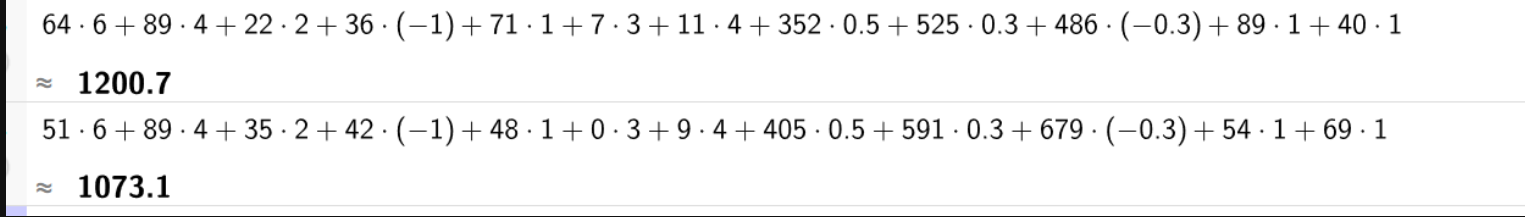

Pisteet ovat samat kahdella parhaalla, joten vaikuttaa siltä että laskeminen on onnistunut

In [28]:
# Poistetaan rivit, joissa pelattujen pelien määrä on alle 40
merged_df = merged_df.drop(merged_df[merged_df['Games'] < 40].index)

# Suodatetaan valitaan dataframesta myös pelaajat jotka ovat pelanneet viimeisimmällä kaudella, tällöin saadaan pois kaikki lopettaneet 
merged_df = merged_df.groupby('Player Name').filter(lambda x: 2023 in x['season'].values)

merged_df

,Player Name,Team,season,Pos,Games,G,A,Pts,+/-,PIM,SOG,GWG,H,BL,FW,FL,PPP,SHP,Fantasy Points
4602,Connor McDavid,EDM,2022,C,82,64,89,153,22,36,352,11,89,40,525.0,486.0,71,7,1200.7
5558,Nathan MacKinnon,COL,2023,C,82,51,89,140,35,42,405,9,54,69,591.0,679.0,48,0,1073.1
5555,Auston Matthews,TOR,2023,C,81,69,38,107,31,20,369,8,90,93,683.0,586.0,29,1,1068.6
4604,David Pastrnak,BOS,2022,RW,82,61,52,113,34,38,407,13,91,33,8.0,11.0,37,0,1019.6
5573,J.T. Miller,VAN,2023,C,81,37,66,103,32,58,194,9,216,61,813.0,627.0,40,2,1003.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6091,Adam Ruzicka,FA,2023,C,42,3,6,9,-9,12,35,1,10,16,86.0,97.0,4,0,60.2
5247,Sam Carrick,EDM,2022,C,52,3,4,7,-17,86,50,0,98,24,182.0,187.0,0,0,59.5
3106,Trent Frederic,BOS,2020,C,42,4,1,5,-8,65,44,3,61,15,37.0,33.0,0,0,58.2
6146,Kurtis MacDermid,NJ,2023,LW,45,2,1,3,4,73,16,1,83,11,2.0,0.0,0,0,57.6


Nyt kun dataa on käsitelty, siitä on poistettu tarpeettomia tietoja, voidaan alkaa visualisoimaan dataa, piirretään kuvaaja 10 randomilla valitun pelaajan Fantasy Points pisteiden muutoksesta 2017-2023 vuosien aikana

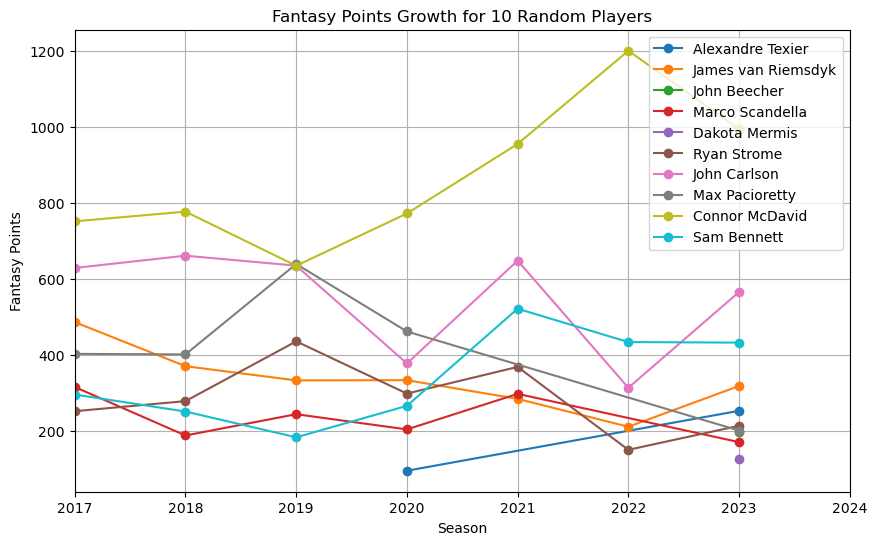

In [29]:
# Jotta käyrä saadaan pirrettyä fiksusti tulee sorttaaminen tehdä season sarakkeen mukaan
# Tällöin käyrä kulkee aina vuodesta seuraavaan
merged_df = merged_df.sort_values(by='season', ascending=False)

# Ryhmittellään pelaajat
pelaajat = merged_df.groupby('Player Name')

# Valitaan satunnaisesti 10 pelaajaa
satunnaiset_pelaajat = random.sample(list(pelaajat.groups.keys()), 10)

# Luodaan tyhjä DataFrame Fantasy Points -käyrien tallentamiseksi
kasvukayra = pd.DataFrame(columns=['Player Name', 'Kasvukäyrä'])

for nimi in satunnaiset_pelaajat:
    pelaaja = pelaajat.get_group(nimi)
    # Laske Fantasy Points -käyrä
    fantasy_pisteet_kayra = pelaaja['Fantasy Points'].diff().fillna(0)
    
    # Lisää kasvukäyrä DataFrameen
    kasvukayra = pd.concat([kasvukayra, pd.DataFrame({'Player Name': [nimi], 'Kasvukäyrä': [fantasy_pisteet_kayra.sum()]})], ignore_index=True)

# Piirrä kasvukäyrät
plt.figure(figsize=(10, 6))
for i, nimi in enumerate(satunnaiset_pelaajat):
    pelaaja_kasvu = kasvukayra.loc[kasvukayra['Player Name'] == nimi]
    plt.plot(pelaajat.get_group(nimi)['season'], pelaajat.get_group(nimi)['Fantasy Points'], marker='o', label=nimi)

plt.xlabel('Season')
plt.ylabel('Fantasy Points')
plt.title('Fantasy Points Growth for 10 Random Players')
plt.legend()
plt.grid(True)
plt.xlim(2017, 2024)
plt.show()


Käyrien avulla voidaan katsoa miten yksittäisen pelaajan Fantasy Points pisteiden määrä on vaihdellut kausien välillä. Käyrästä voidaan hieman päätellä mihin suuntaan pelaajan tehokkuus on menossa ja millaisia tuloksia voidaan odottaa jatkossa.
Alla olevalla koodilla, voidaan piirtää valitun pelaajan osalta käyrä, tällöin voidaan tutkia hieman tarkemmin yhden pelaajan pistekehitystä

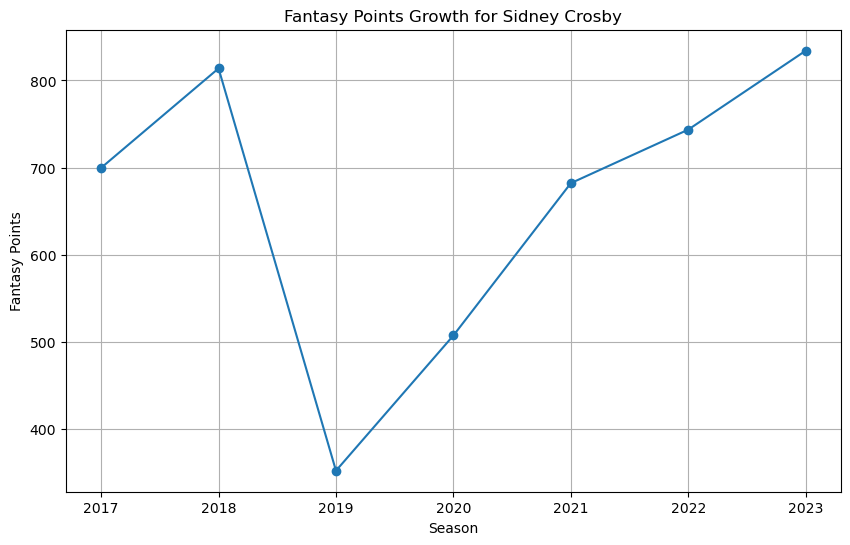

In [30]:
# Syötä haluamasi pelaajan nimi tähän
haluttu_pelaaja = "Sidney Crosby"

# Ryhmitellään pelaajat
pelaajat = merged_df.groupby('Player Name')

# Tarkistetaan, onko haluttu pelaaja olemassa
if haluttu_pelaaja in pelaajat.groups:
    # Haetaan halutun pelaajan tiedot
    pelaaja = pelaajat.get_group(haluttu_pelaaja)
    
    # Lasketaan Fantasy Points -käyrä
    fantasy_pisteet_kayra = pelaaja['Fantasy Points'].diff().fillna(0)

    # Piirretään kasvukäyrä
    plt.figure(figsize=(10, 6))
    plt.plot(pelaaja['season'], pelaaja['Fantasy Points'], marker='o')

    plt.xlabel('Season')
    plt.ylabel('Fantasy Points')
    plt.title(f'Fantasy Points Growth for {haluttu_pelaaja}')
    plt.grid(True)
    plt.show()
else:
    print(f"Pelaajaa {haluttu_pelaaja} ei löytynyt.")

Aiemman datan perusteella voidaan luoda koneoppimismalli, joka ennustaa seuraavan kauden eli season 2024 pelaajien pisteitä, kyseisen ennakointimallin ja sen tulkinnan avulla pyritään saavuttamaan kilpailuetua muihin kisailijoihin nähden. Mikäli datan pohjalta osataan valita jokin pelaaja tulevalle vuodelle, joka onnistuu mallin mukaisesti tuottamaan pisteitä yllätyksellisen paljon, saadaan merkittävästi kilpailuetua muihin kisailijoihin nähden.

In [31]:
# Uusi DataFrame tarvittavilla sarakkeilla
new_df = merged_df[['Player Name', 'Team', 'season', 'Pos', 'Fantasy Points']].copy()

# Dataframessa on tiedot pelaajien Fantasy Pointseista kullekin kaudelle
new_df = new_df.pivot_table(index=['Player Name', 'Team', 'Pos'], columns='season', values='Fantasy Points').reset_index()

# Korvaa mahdolliset NaN-arvot nollilla
new_df.fillna(0, inplace=True)

# Erota ominaisuudet (features) ja ennustettavat arvot (target values)
X = new_df.drop(columns=['Player Name', 'Team', 'Pos'])
y = new_df.drop(columns=['Player Name', 'Team', 'Pos'])  # Käytetään kaikkia vuosia ennustamiseen

# Mallin luonti ja koulutus
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Luodaan kopio DataFramesta uusilla ennustetuilla arvoilla
predicted_df = new_df.copy()

# Ennusteiden tekeminen
predictions = model.predict(X)

# Ennusteiden lisääminen predicted_df
predicted_df[2024] = predictions[:, -1]  # Otetaan viimeinen ennustettu arvo

predicted_df = predicted_df.sort_values(by=2024, ascending=False)
predicted_df

season,Player Name,Team,Pos,2017,2018,2019,2020,2021,2022,2023,2024
50,Auston Matthews,TOR,C,580.1,601.5,759.8,665.7,983.9,870.8,1068.6,1004.6470
412,Nathan MacKinnon,COL,C,661.9,767.8,709.8,491.2,698.1,863.0,1073.1,995.3360
129,Connor McDavid,EDM,C,751.9,777.4,635.0,772.5,955.4,1200.7,994.1,968.8510
214,J.T. Miller,VAN,C,510.2,426.2,641.9,370.6,872.3,775.9,1003.8,906.4740
148,David Pastrnak,BOS,RW,623.5,628.2,763.3,389.1,686.9,1019.6,861.0,856.5265
...,...,...,...,...,...,...,...,...,...,...,...
440,Nils Aman,VAN,C,0.0,0.0,0.0,0.0,0.0,116.4,82.5,82.1980
8,Adam Ruzicka,FA,C,0.0,0.0,0.0,0.0,0.0,161.6,60.2,78.5000
326,Kurtis MacDermid,NJ,LW,0.0,0.0,139.5,0.0,87.0,99.7,57.6,72.3440
494,Ross Johnston,ANH,LW,0.0,0.0,0.0,0.0,0.0,0.0,65.0,66.3890


Tutkitaan ennusteita season 2024 kohdalta ja erityisesti miten ne ovat kehittyneet edelliseen vuoteen verrattuna ja tehdään niistä piirrosgraafi kuten aiemmin

In [32]:
# Lisätään uusi sarake, joka sisältää kasvuprosentin
predicted_df['Growth'] = (predicted_df[2024] - predicted_df[2023]) / predicted_df[2023] * 100

# Valitaan 10 suurinta kehitystä 2023-2024 vuosien välillä
top_10_growth = predicted_df.nlargest(10, 'Growth')

top_10_growth

season,Player Name,Team,Pos,2017,2018,2019,2020,2021,2022,2023,2024,Growth
154,Dillon Dube,CGY,C,0.0,0.0,181.4,205.3,332.5,408.5,75.9,136.624,80.005270
22,Alexander Barabanov,SJ,RW,0.0,0.0,0.0,0.0,307.2,295.7,77.2,135.487,75.501295
577,Tyson Barrie,NSH,D,454.0,505.0,355.5,397.0,364.5,460.5,125.5,206.080,64.207171
318,Kevin Labanc,SJ,RW,297.2,401.5,232.3,237.7,0.0,258.1,78.6,128.810,63.880407
32,Andre Burakovsky,SEA,LW,235.9,243.2,365.3,327.0,481.3,258.7,120.0,190.652,58.876667
460,Patrick Maroon,BOS,LW,391.9,286.0,211.0,132.0,264.0,122.0,117.0,171.116,46.252991
134,Conor Sheary,TB,LW,299.1,266.7,203.7,193.8,370.0,364.3,128.7,185.948,44.481740
579,Tyson Jost,BUF,C,176.4,254.5,221.0,193.7,192.9,165.7,77.0,109.505,42.214286
111,Chris Tierney,NJ,C,349.0,302.0,302.2,136.9,166.1,0.0,92.6,130.721,41.167387
418,Nick Bonino,FA,C,268.7,384.7,379.4,216.7,290.0,197.7,95.9,133.003,38.689260


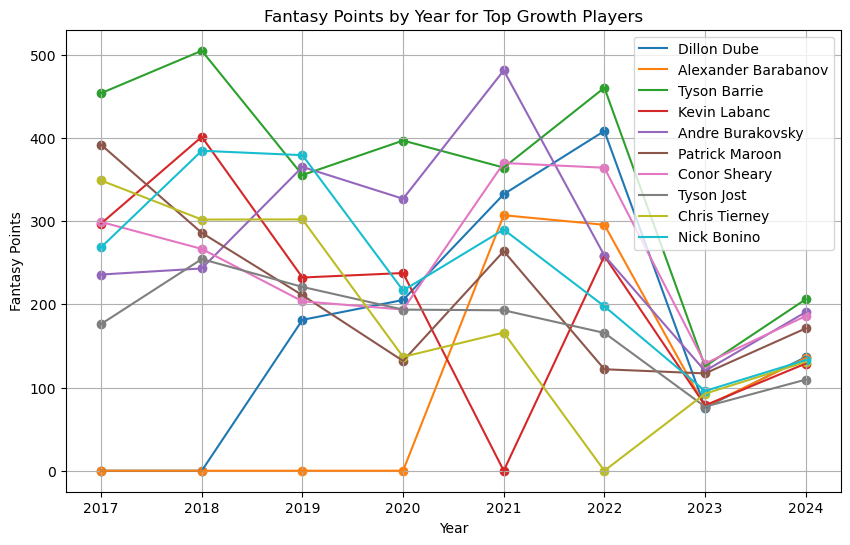

In [33]:
plt.figure(figsize=(10, 6))

# Käy läpi jokainen pelaaja ja piirrä käyrä
for _, row in top_10_growth.iterrows():
    player_name = row['Player Name']
    points = row.drop(['Player Name', 'Team', 'Pos', 'Growth'])
    years = points.index.astype(int)  # Muunna indeksin vuosiluvuiksi
    
    plt.plot(years, points, label=player_name)

    plt.scatter(years, points)
plt.title('Fantasy Points by Year for Top Growth Players')
plt.xlabel('Year')
plt.ylabel('Fantasy Points')

plt.legend()
plt.grid(True)
plt.show()

Kaaviosta nähdään, että pelaajat joilla on ennen vuotta 2023 ollut hyviä tuloksia, mutta 2023 heillä on mennyt aiempaa heikommin, saavat ennusteessa suuren kasvun edelliseen vuoteen verrattuna. Jos tutkittan myös yleisesti ennusteita 2024 kaudelle näkyy tämä ennusteissa selvästi. Tosin, tulee huomioida, että pelaajien pelimääriä ei tässä enää näy ja kyseiset pelimäärät vaikuttavat merkittävästi siihen mihin suuntaan pistekehitys on kehittynyt.


In [34]:
predicted_df

season,Player Name,Team,Pos,2017,2018,2019,2020,2021,2022,2023,2024,Growth
50,Auston Matthews,TOR,C,580.1,601.5,759.8,665.7,983.9,870.8,1068.6,1004.6470,-5.984746
412,Nathan MacKinnon,COL,C,661.9,767.8,709.8,491.2,698.1,863.0,1073.1,995.3360,-7.246669
129,Connor McDavid,EDM,C,751.9,777.4,635.0,772.5,955.4,1200.7,994.1,968.8510,-2.539885
214,J.T. Miller,VAN,C,510.2,426.2,641.9,370.6,872.3,775.9,1003.8,906.4740,-9.695756
148,David Pastrnak,BOS,RW,623.5,628.2,763.3,389.1,686.9,1019.6,861.0,856.5265,-0.519570
...,...,...,...,...,...,...,...,...,...,...,...,...
440,Nils Aman,VAN,C,0.0,0.0,0.0,0.0,0.0,116.4,82.5,82.1980,-0.366061
8,Adam Ruzicka,FA,C,0.0,0.0,0.0,0.0,0.0,161.6,60.2,78.5000,30.398671
326,Kurtis MacDermid,NJ,LW,0.0,0.0,139.5,0.0,87.0,99.7,57.6,72.3440,25.597222
494,Ross Johnston,ANH,LW,0.0,0.0,0.0,0.0,0.0,0.0,65.0,66.3890,2.136923


Nyt kun ennusteessa näkyy myös Growth sarakkeessa 2023 vuoden ja ennusteen elii 2024 vuosien välinen ero, huomataan, että ennustemalli ennustaa pisteiden vähenevän. Ennustemalli ei kuitenkaan ota huomioon muutamaa ns koronakautta, jolloin runkosarjassa pelattiin vähemmän otteluita. Malli ei myöskään osaa ottaa huomioon yleistä nhl maalimäärien kasvua, joka lisää pisteitä. Jos ei kuitenkaan keskitytä liikaa siihen, että pisteiden oletetaan laskevan, näyttää ennustemalli realistiselle. Ennustemalli suosii pelaajia, joilla pistemäärä on pysyny tasaisena, eikä se ole heilunut vuodesta toiseen merkittävästi suuntaan tai toiseen. 

Pelaajia valitessa on kuitenkin oleellista valita parhaat pelaajat, tämän vuoksi olen jokaisen pelipaikan osalta laittanut pelaajat nyt järjestykseen ennakoitujen pisteiden mukaan, tällaisella taulukolla, pystyn seuraavassa pelaajien varaustilaisuudessa valitsemaan pelaajan joka on datan pohjalta paras, eikä päätös perustu tunteeseen tai sen hetkiseen fiilikseen, tällöin kasvatan mahdollisuuttani voittamiseen. Eri pelipaikoille valitaan eri määrä pelaajia, C, LW ja RW paikoille jokainen valitsee 3 pelaajaa, ja D paikalle jokainen valitsee 6 pelaajaa, tämä on siis otettu huomioon pelipaikkakohtaisia dataframeja luodessa

In [35]:
# Järjestä predicted_df DataFrame 2024 vuoden Fantasy Pointsin perusteella
predicted_df_sorted = predicted_df.sort_values(by=2024, ascending=False)

# Luo DataFrame Top_30_Center_2024
Top_30_Center_2024 = predicted_df_sorted[predicted_df_sorted['Pos'] == 'C'].head(30)

# Luo DataFrame Top_30_Right_Wing_2024
Top_30_Right_Wing_2024 = predicted_df_sorted[predicted_df_sorted['Pos'] == 'RW'].head(30)

# Luo DataFrame Top_30_Left_Wing_2024
Top_30_Left_Wing_2024 = predicted_df_sorted[predicted_df_sorted['Pos'] == 'LW'].head(30)

# Luo DataFrame Top_60_Defense_2024
Top_60_Defense_2024 = predicted_df_sorted[predicted_df_sorted['Pos'] == 'D'].head(60)

In [36]:
Top_30_Center_2024

season,Player Name,Team,Pos,2017,2018,2019,2020,2021,2022,2023,2024,Growth
50,Auston Matthews,TOR,C,580.1,601.5,759.8,665.7,983.9,870.8,1068.6,1004.6470,-5.984746
412,Nathan MacKinnon,COL,C,661.9,767.8,709.8,491.2,698.1,863.0,1073.1,995.3360,-7.246669
129,Connor McDavid,EDM,C,751.9,777.4,635.0,772.5,955.4,1200.7,994.1,968.8510,-2.539885
214,J.T. Miller,VAN,C,510.2,426.2,641.9,370.6,872.3,775.9,1003.8,906.4740,-9.695756
534,Sidney Crosby,PIT,C,699.6,813.8,351.8,507.1,682.0,743.5,834.1,812.6905,-2.566779
334,Leon Draisaitl,EDM,C,517.8,733.0,749.8,669.1,882.9,990.7,803.6,802.8245,-0.096503
587,Vincent Trocheck,NYR,C,732.4,346.9,346.9,430.4,583.5,662.3,827.6,770.8495,-6.857238
172,Elias Pettersson,VAN,C,0.0,495.1,555.7,0.0,539.8,837.6,829.1,761.1750,-8.192619
11,Aleksander Barkov,FLA,C,672.6,728.6,477.3,525.1,796.2,673.0,753.9,726.1010,-3.687359
276,John Tavares,TOR,C,633.5,798.0,487.6,455.2,685.7,768.2,724.2,718.1305,-0.838097


In [37]:
Top_30_Right_Wing_2024 

season,Player Name,Team,Pos,2017,2018,2019,2020,2021,2022,2023,2024,Growth
148,David Pastrnak,BOS,RW,623.5,628.2,763.3,389.1,686.9,1019.6,861.0,856.5265,-0.519570
435,Nikita Kucherov,TB,RW,715.8,857.1,629.7,0.0,457.3,763.1,968.0,837.7110,-13.459607
401,Mikko Rantanen,COL,RW,568.9,623.9,326.4,536.5,717.2,819.3,812.9,796.4845,-2.019375
190,Filip Forsberg,NSH,RW,584.2,513.7,420.7,0.0,754.3,383.2,895.5,778.8245,-13.029090
515,Sam Reinhart,FLA,RW,392.0,454.5,339.1,279.8,660.7,572.3,850.2,776.4570,-8.673606
607,Zach Hyman,EDM,RW,449.8,400.8,327.7,334.8,464.6,663.0,756.4,709.0800,-6.255949
404,Mitchell Marner,TOR,RW,481.5,688.8,465.7,512.9,763.6,725.8,643.0,649.6680,1.037014
529,Seth Jarvis,CAR,RW,0.0,0.0,0.0,0.0,364.1,412.1,676.1,645.5290,-4.521668
264,Joe Pavelski,DAL,RW,595.7,592.6,351.6,500.2,711.1,741.1,607.7,626.4380,3.083429
88,Brock Boeser,VAN,RW,427.8,413.9,356.1,361.7,402.8,386.1,631.4,598.0610,-5.280171


In [38]:
Top_30_Left_Wing_2024

season,Player Name,Team,Pos,2017,2018,2019,2020,2021,2022,2023,2024,Growth
47,Artemi Panarin,NYR,LW,588.90,584.9,683.5,382.1,633.50,586.9,839.10,798.0010,-4.897986
68,Brady Tkachuk,OTT,LW,0.00,457.1,572.9,474.1,665.30,726.0,780.10,754.6750,-3.259198
322,Kirill Kaprizov,MIN,LW,0.00,0.0,0.0,407.1,843.80,633.2,765.20,714.8560,-6.579195
377,Matthew Tkachuk,FLA,LW,395.10,594.2,477.8,392.2,837.60,773.1,714.10,704.5850,-1.332446
527,Sebastian Aho,CAR,LW,513.45,693.6,542.4,473.7,686.15,570.2,724.35,692.4240,-4.407538
109,Chris Kreider,NYR,LW,336.50,538.1,460.2,350.5,822.10,609.1,694.20,675.5215,-2.690651
18,Alex Ovechkin,WAS,LW,815.90,912.1,709.8,442.4,855.50,698.7,629.40,672.6105,6.865348
249,Jason Robertson,DAL,LW,0.00,0.0,0.0,347.4,657.00,883.2,661.50,648.0690,-2.030385
230,Jake Guentzel,CAR,LW,465.50,676.5,0.0,452.7,690.30,620.0,617.70,622.5610,0.786952
259,Jesper Bratt,NJ,LW,258.90,241.8,255.4,247.6,523.60,565.0,641.20,613.9220,-4.254211


In [39]:
Top_60_Defense_2024

season,Player Name,Team,Pos,2017,2018,2019,2020,2021,2022,2023,2024,Growth
491,Roman Josi,NSH,D,625.5,594.7,612.0,315.5,794.5,621.5,752.0,722.2520,-3.955851
93,Cale Makar,COL,D,0.0,0.0,423.5,385.0,853.0,585.0,771.5,712.0450,-7.706416
345,MacKenzie Weegar,CGY,D,220.0,276.8,254.2,433.5,644.5,512.0,725.0,699.2460,-3.552276
183,Evan Bouchard,EDM,D,0.0,0.0,0.0,0.0,496.5,434.0,749.0,677.1230,-9.596395
483,Rasmus Dahlin,BUF,D,0.0,421.5,307.0,197.5,459.0,633.0,697.5,644.2120,-7.639857
445,Noah Dobson,NYI,D,0.0,0.0,0.0,194.5,571.0,504.0,682.0,641.7340,-5.904106
477,Quinn Hughes,VAN,D,0.0,0.0,334.7,229.0,471.0,528.0,669.5,633.4580,-5.383420
409,Moritz Seider,DET,D,0.0,0.0,0.0,0.0,610.5,608.0,631.5,627.7510,-0.593666
297,Josh Morrissey,WPG,D,460.0,373.8,277.0,296.0,467.5,645.0,634.0,621.4980,-1.971924
3,Adam Fox,NYR,D,0.0,0.0,414.5,430.7,612.0,621.5,626.5,612.0810,-2.301516


Kyseisten dataframeien perusteella, kun pelaajat on nyt asetettu järjestykseen ennakoitujen pisteiden osalta, osaan seuraavassa pelaajien varaustilaisuudessa luottaa dataan ja tehdä pelaajavalinnat datan pohjalta. Tällöin tunteiden, hetken mielijohteen tai paniikin tunteen ei ole mahdollista vaikuttaa päätöksiini. Mikäli en menesty kisailussa, voin syyttää siitä vain itseäni ja heikkoa osaamistani liittyen datan tutkimiseen ja koneoppimismallien käyttämiseen. Päätökseni ovat kuitenkin dataan perustuvia, joten luotan niiden olevan järkeviä ja muita parempia. Kun perustan päätökseni dataan luon etua itselleni verrattuna muihin kisailijoihin. Uskon tämän edun olevan merkittävässä asemassa ja parantavan mahdollisuuksiani voittoon.